<a href="https://colab.research.google.com/github/davina-h/PRA3024/blob/main/Kopie_von_ML_cifar_CNN_exercise_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')
    
    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)
    
        

    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)
    

def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):
    
    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]
    
    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)
    
    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255                                                      #--> figure_shape = ([-1,3,32,32])
    y_test = np.array(test_batch["labels"]).astype('int32')
    
    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]                                                                             #--> figure_shape = ([-1,32,32,3])
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])

    
    return X_train,y_train,X_val,y_val,X_test,y_test

In [9]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.3


In [10]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]                                                            #--> label_number = 10

print("Train samples:", x_train.shape, y_train.shape)                                                                  #--> sample_shape = 32,32,3
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


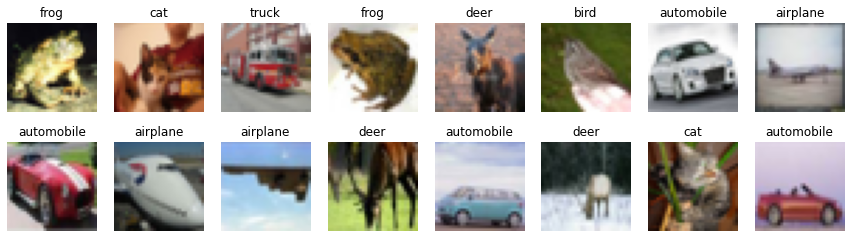

In [11]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [12]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [13]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout     #--> layers to add
from keras.layers.advanced_activations import LeakyReLU

In [22]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """

    model = Sequential()
    
    from keras.regularizers import l2
    from keras.layers import BatchNormalization

    #Layer set 1
    #Convolutional Layer 1
    model.add(Conv2D(filters=32,kernel_size=(3,3), input_shape=(32,32,3), strides=(1,1),padding="same",)) #activated padding to prevent size reduction
    model.add(BatchNormalization()) #normalizes output of previous layer so network can work with assumed constant layer outputs which reduces training time
    model.add(LeakyReLU(alpha=0.1)) #allows slope for output of negtive inputs to prevent fixed zeros; 0.1 gives best accuracy

    #Convolutional Layer 2 to increase number of detected features/network's "field of vision"
    model.add(Conv2D(filters=32,kernel_size=(3,3), input_shape=(32,32,3), strides=(1,1),padding="same",))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))

    #Pooling layer (picks pixels with highest values and decreases matrix size)
    model.add(MaxPooling2D(pool_size=(3,3)))

    #Dropout layer (to minimize overfitting by randomly ignoring nodes)
    model.add(Dropout(0.2))
    

    #Layer set 2
    #Convolutional Layer 1 (filter size doubled to half matrix loss due to pooling)
    model.add(Conv2D(filters=64,kernel_size=(3,3), input_shape=(32,32,3), strides=(1,1),padding="same",))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))

    #Convolutional Layer 2
    model.add(Conv2D(filters=64,kernel_size=(3,3), input_shape=(32,32,3), strides=(1,1),padding="same",))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))

    #Pooling Layer
    model.add(MaxPooling2D(pool_size=(3,3)))

    #Dropout Layer
    model.add(Dropout(0.2))


    #Layer Set 3 (3 was the optimum between overfitting and accuracy)
    #Convolutional Layer 1 (filter size doubled to half matrix loss due to pooling)
    model.add(Conv2D(filters=128,kernel_size=(3,3), input_shape=(32,32,3), strides=(1,1),padding="same",))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))

    #Convolutional Layer 2
    model.add(Conv2D(filters=128,kernel_size=(3,3), input_shape=(32,32,3), strides=(1,1),padding="same",))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))

    #Pooling Layer
    model.add(MaxPooling2D(pool_size=(3,3)))

    #Dropout layer
    model.add(Dropout(0.2))


    #Flattening Layer (converts matrix into 1D-Vector as needed by the dense layers)
    model.add(Flatten())

    #Dense Layers (2 to increase number of connections and therefore accuracy)
    model.add(Dense(units=256))
    model.add(LeakyReLU(alpha=0.1))

    model.add(Dense(units=128))
    model.add(LeakyReLU(alpha=0.1))

    #Dropout layer
    model.add(Dropout(0.6)) #increased dropout rate as increased number of nodes

    #Dense Layer (to match output with number of labels)
    model.add(Dense(units=10))

    #Ensure normalized probabilities over the 10 classes
    model.add(Activation("softmax")) 

    return model

In [23]:
INIT_LR = 3e-3  #reduced to 3
BATCH_SIZE = 128 #best accuracy in least amount of time
EPOCHS = 50 #best accuracy in least amount of time

Early_Stopping = keras.callbacks.EarlyStopping( #early stopping function to minimize overfitting
    monitor="val_accuracy",
    min_delta=0.01,
    patience=5,
    mode="auto",
    restore_best_weights=True,
)

K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adamax(lr=INIT_LR),  # for SGD.
    metrics=['accuracy']  # report accuracy during training
)

# fit model
history = model.fit(
    x_train, y_train,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,
    callbacks=Early_Stopping,
)

# save weights to file to avoid re-training
model.save_weights("weights.h5")

Epoch 1/50
313/313 [==============================] - 6s 15ms/step - loss: 1.9761 - accuracy: 0.2687 - val_loss: 3.0092 - val_accuracy: 0.1271
Epoch 2/50
313/313 [==============================] - 5s 14ms/step - loss: 1.3943 - accuracy: 0.4962 - val_loss: 1.2735 - val_accuracy: 0.5381
Epoch 3/50
313/313 [==============================] - 5s 14ms/step - loss: 1.1649 - accuracy: 0.5838 - val_loss: 1.0282 - val_accuracy: 0.6300
Epoch 4/50
313/313 [==============================] - 5s 14ms/step - loss: 1.0375 - accuracy: 0.6375 - val_loss: 0.9761 - val_accuracy: 0.6592
Epoch 5/50
313/313 [==============================] - 5s 14ms/step - loss: 0.9279 - accuracy: 0.6797 - val_loss: 0.8671 - val_accuracy: 0.6945
Epoch 6/50
313/313 [==============================] - 5s 14ms/step - loss: 0.8487 - accuracy: 0.7064 - val_loss: 0.9582 - val_accuracy: 0.6862
Epoch 7/50
313/313 [==============================] - 5s 15ms/step - loss: 0.7941 - accuracy: 0.7286 - val_loss: 0.9435 - val_accuracy: 0.6868

In [24]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

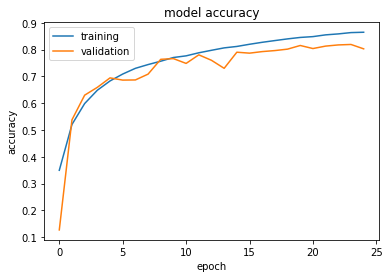

In [25]:
#Graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


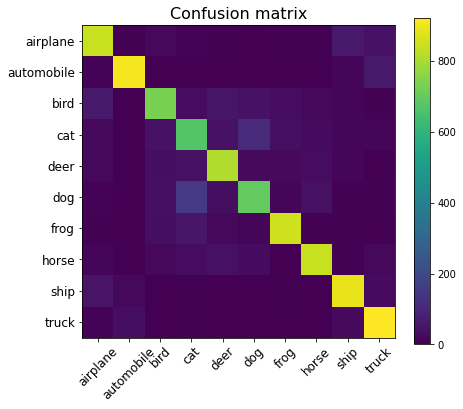

Test accuracy: 0.8172


In [26]:
# make test predictions
y_pred_test = model.predict_proba(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

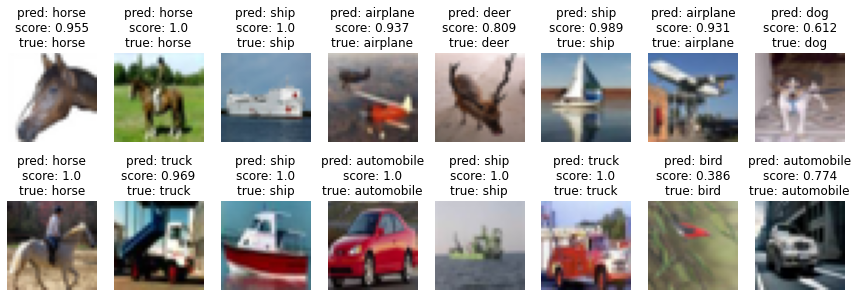

In [28]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons, 
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ - 
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.




**Report**

My iteration description has a lot of background information as it took me a while to fully understand everything I am doing so I am describing in my own words how I understood it. If I misunderstood anything I would be very glad if you could tell me.

**Input**

The input is an image with 32x32 pixels x3 colours (RGB). An RGB image is an image composed of three colours (red, green and blue). Each pixel has a percentage of red, green and blue and the image therefore becomes 3 dimensional with colour being the third dimension.

**Convolutional Layer**

In the convolutional Layer one or more filters (grids of for example 3x3 pixels with different numbers on each pixel which can change as the model learns) move along the image multiplying the value of the filter pixel with the value of the image pixel and adding the results to get one number (shrinking 9 values/pixels to 1 value/pixel). However, the filter does not move in steps of 3 but only 1 (can be changed in strides=( , )). Therefore we only reduce the number of pixels by one row/column of pixels on the top, bottom, left and right. This means we shrink the image from 32x32 pixels to 30x30 pixels.

**Padding**

To avoid losing the edges we can do padding (padding=”same”) which means that we add pixels with zeros around the image (as convolution is about first multiplying and then adding they do not change the result).

**Batch Normalization Layer**

During backpropagation the weights of each layer is changed with the assumption that the weights of all other layers remain constant. However, the weights of all layers are being changed which is why it can take very long until the model is accurate. The Batch Normalization Layer normalizes the inputs of a layer so that the model can work with the assumption that the output of previous layers is constant. Batch normalization therefore reduces the epochs it takes to get an accurate model. 

**LeakyReLu Activation Layer**

The output of a convolutional filter is a new matrix of pixels. We can continue working with this output. It therefore becomes the input of something else. An activation function works in between. It changes the output of the convolutional filter so it is better input for the next thing that will work with it. The ReLu function keeps all the positive values as they are and changes all the negative values to zeros. For example; if we have -1,2,4,-2 as output from the convolutional filter, the activation function will change it to 0,2,4,0 and this will be the input for the next layer. However, once a negative number is changed to zero it stays zero which can be a disadvantage. The LeakyReLu activation function does not change the negative values to zero (meaning the slope of the function is zero for all negative inputs) but so that the slope of the function for all negative inputs is a preset value slightly bigger than zero (alpha = ).

**Pooling Layer**

Next we do pooling or more precisely max pooling. This means that you divide the image into sections of e.g. 2x2 pixels and only take the largest value of each section. This makes the image a lot smaller and reduces the computational power needed. E.g. with a 2x2 max pooling a 28x28 pixel image is reduced to one 4th of the pixels (14x14). However, instead of using a pooling layer, we can also use another convolutional layer with strides set greater than 1 e.g. 2x2. This means that the pooling filter moves in steps of two (horizontally as well as vertically) reducing the size of the output matrix. I am using this method as I have found it to increase the validation accuracy. While at first this method increased my accuracy, as I added more layers MaxPooling has proven to be the better method for my network.

**Flattening Layer**

Flattening is making a long column from a grid because the dense layer needs a 1D vector as input.

**Dense Layer**

In the fully connected (Dense) NN (Neural Network) layer each neuron (called node) will be connected to each label (called class) and given a weight (from 0 to 1 how important is this feature for a cat, dog, truck etc.).

**Dropout Layer**

When you have a small dataset you often have overfitting, however, large datasets need large computational power. We therefore use a Dropout layer to prevent overfitting by randomly dropping out (ignorig) nodes and their connections. During training we go through the layers multiple times and due to Dropout each time has a different perspective as if we had a large dataset.
Dense Layer with class shape
As we have 10 labels/classes we add another dense layer so that our output shape matches our number of classes.

**Softmax Layer**

There is an x% chance of the image being a dog, a y% chance of it being a cat etc. The softmax is used to normalize theses probabilities meaning so that they all together add up to 1.

**Detailed Description of my Model Architecture and Reasoning**

For my model, I start with 32 filters in the convolution layer and double the filter number after each pooling as pooling reduces the number of values to one 4th so by doubling the filter number the number of values is only halved. I use a kernel size of 3x3 as this gives me the best accuracy. I use two identical convolutional layers (including padding, LeakyReLu (alpha=0.1 gave the best accuracy) and Batch Normalization) before pooling as this allows the network to detect more features. I repeat this set of layers 2 more times as this was the optimal number of repeated layer sets that minimizes overfitting and maximizes val_accuracy in my network. To further minimize overfitting I added a dropout layer after each pooling and the last dense layer. For low filter values I used a lower dropout rate and increased it as the number of filters increased so that I do not drop out too many nodes when the node number is still low. I also added an early stopping function that stops the training if the val_accuracy doesn´t increase by at least 0.01 over 5 epochs to reduce overfitting. To increase the accuracy I use two dense layers after each other as this increases the number of connections.
